In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import datetime
import requests
from tqdm import tqdm

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.deterministic import Fourier
from statsmodels.tsa.tsatools import add_trend
import statsmodels.api as sm
import holidays

from watermark import watermark

print(watermark())

Last updated: 2024-08-11T17:59:53.311582+03:00

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.21.0

Compiler    : GCC 14.2.0
OS          : Linux
Release     : 6.10.2-gentoo
Machine     : x86_64
Processor   : AMD Ryzen 9 5950X 16-Core Processor
CPU cores   : 32
Architecture: 64bit



## Загрузка данных

In [2]:
time_history_url = "https://deepstatemap.live/api/history/public"

In [3]:
# Making a get request
response = requests.get(time_history_url)

df = pd.DataFrame()
# print json content
t = len(response.json())
Path("data/").mkdir(exist_ok=True)
with tqdm(total=t) as pbar:
    for n, i in enumerate(response.json()):
        timestamp = i["id"]
        time_index = datetime.datetime.fromtimestamp(timestamp)
        pbar.set_description(str(time_index.date()), refresh=True)

        area = requests.get(
            f"https://deepstatemap.live/api/history/{timestamp}/areas")
        js_df = pd.json_normalize(area.json()).assign(time_index=time_index)
        df = pd.concat([df, js_df], ignore_index=True)
        pbar.update(1)
df

2022-04-06:   1%|▏         | 14/1004 [00:02<02:22,  6.93it/s]

In [ ]:
df.set_index("time_index", inplace=True)
df = df.astype(
    {"percent": "float32", "area": "float64", "hash": "string", "type": "category"}
)

In [ ]:
df.to_csv(Path("data/area_history.csv"))

# Моделирование краткосрочного момента


In [2]:
try:
    df
except NameError:
    df = None
if df is None:
    td = (
        datetime.datetime.now().timestamp()
        - Path("data/area_history.csv").stat().st_ctime
    )
    if td >= 60 * 60 * 24:
        print("Данные устарели!")
    df = pd.read_csv(
        Path("data/area_history.csv"),
        index_col="time_index",
        parse_dates=True,
        dtype={
            "percent": "float32",
            "area": "float64",
            "hash": "string",
            "type": "category",
        },
    )

In [3]:
df

,hash,area,percent,type
time_index,,,,
2022-04-03 15:33:28,#a52714,63864.643990,10.579000,occupied_after_24_02_2022
2022-04-03 15:33:28,#880e4f,46937.208199,7.775000,occupied_to_24_02_2022
2022-04-03 15:33:28,#bcaaa4,5587.522472,0.926000,unspecified
2022-04-03 15:33:28,#0f9d58,14012.882652,2.321000,liberated
2022-04-03 19:46:15,#a52714,63864.643990,10.579000,occupied_after_24_02_2022
...,...,...,...,...
2024-08-10 17:03:54,#ff5252,139991.513798,23.188999,other_territories
2024-08-10 17:03:54,#880e4f,43974.128584,7.284000,occupied_to_24_02_2022
2024-08-10 17:03:54,#a52714,65557.402044,10.859000,occupied_after_24_02_2022


In [13]:
area_dinamic = (
    df.dropna()
    .groupby([pd.Grouper(freq="D"), "type"])[["area", "percent"]]
    .mean()
    .reset_index()
    .set_index("time_index")
)
last_date = df.index.max().strftime("%Y-%m-%d %X")

/tmp/ipykernel_31278/3457041684.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([pd.Grouper(freq="D"), "type"])[["area", "percent"]]


In [14]:
occupied_by_ua = (
    df[
        (df["type"] == "other_territories") &
        (df['hash'] == '#01579b')
    ]
    .groupby(pd.Grouper(freq="D"))[["area", "percent"]]
    .mean()
)
occupied_by_ua

,area,percent
time_index,,
2024-08-08,142.989574,0.024
2024-08-09,142.989574,0.024
2024-08-10,142.989574,0.024


In [15]:
area_dinamic.dropna(inplace=True)
area_dinamic["type"]

time_index
2022-04-03                    liberated
2022-04-03    occupied_after_24_02_2022
2022-04-03       occupied_to_24_02_2022
2022-04-03                  unspecified
2022-04-04                    liberated
                        ...            
2024-08-10                    liberated
2024-08-10    occupied_after_24_02_2022
2024-08-10       occupied_to_24_02_2022
2024-08-10            other_territories
2024-08-10                  unspecified
Name: type, Length: 3879, dtype: category
Categories (5, object): ['liberated', 'occupied_after_24_02_2022', 'occupied_to_24_02_2022', 'other_territories', 'unspecified']

In [16]:
area_dinamic["type"].unique()

['liberated', 'occupied_after_24_02_2022', 'occupied_to_24_02_2022', 'unspecified', 'other_territories']
Categories (5, object): ['liberated', 'occupied_after_24_02_2022', 'occupied_to_24_02_2022', 'other_territories', 'unspecified']

In [19]:
ru_holidays = holidays.country_holidays("RU")
ua_holidays = holidays.country_holidays("UA")

In [20]:
target_area = 118370
svo_end = pd.to_datetime("2026-11-15")

In [21]:
aa = area_dinamic[area_dinamic["type"] == "occupied_after_24_02_2022"][
    "area"
]  # ["percent"]
aa = pd.DataFrame(
    index=pd.date_range(start=aa.index.min(), end=aa.index.max(), freq="D")
).join(aa)
aa.interpolate(inplace=True)
aa["prefix"] = 0
aa.loc[:"2022-11-11", "prefix"] = 1
aa

,area,prefix
2022-04-03,63714.938326,1
2022-04-04,64256.540524,1
2022-04-05,64193.626525,1
2022-04-06,64261.353774,1
2022-04-07,65046.306239,1
...,...,...
2024-08-06,65509.745474,0
2024-08-07,65530.207291,0
2024-08-08,65530.207291,0
2024-08-09,65534.801845,0


In [22]:
aa['area'] = aa['area'].subtract(occupied_by_ua['area'], fill_value=0)
aa

,area,prefix
2022-04-03,63714.938326,1
2022-04-04,64256.540524,1
2022-04-05,64193.626525,1
2022-04-06,64261.353774,1
2022-04-07,65046.306239,1
...,...,...
2024-08-06,65509.745474,0
2024-08-07,65530.207291,0
2024-08-08,65387.217718,0
2024-08-09,65391.812271,0


In [23]:
best_ff = None
best_aic = 99e99
for order in range(1, 3):
    for period in np.linspace(order * 2, 2 * 365.25, 100):
        fourier_gen = Fourier(period, order)
        ff = fourier_gen.in_sample(aa.index)
        ff["prefix"] = aa["prefix"]
        ff = add_trend(ff, "ct")
        model = sm.OLS(aa["area"], ff).fit()
        if best_ff is None or best_aic > model.aic:
            best_ff = model
best_ff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   area   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     730.7
Date:                Sun, 11 Aug 2024   Prob (F-statistic):               0.00
Time:                        18:02:02   Log-Likelihood:                -7910.2
No. Observations:                 861   AIC:                         1.583e+04
Df Residuals:                     854   BIC:                         1.587e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
sin(1,730.50)   818.7050    145.692      5.619      0.000     532.749    1104.661
cos(1,730.50)  2774.4262    215.895     12.851      0.000    2350.679    3198.173
sin(2,730.50)  2326.4359    134.487     17.299      0.000    2062.472    2590.400
cos(2,730.50)  -577.2900    133.782     -4.315      0.000    -839.870    -314.709
prefix         2903.9654    613.304      4.735      0.000    1700.205    4107.726
const          7.197e+04    528.833    136.094      0.000    7.09e+04     7.3e+04
trend           -12.6602      0.933    -13.570      0.000     -14.491     -10.829
==============================================================================
Omnibus:                      333.087   Durbin-Watson:                   0.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2589.073
Skew:                          -1.553   Prob(JB):                         0.00
Kurtosis:                      10.907   Cond. No.                     5.07e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.07e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<Axes: >

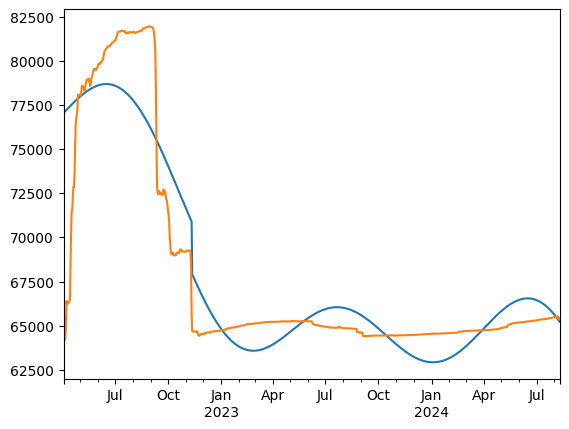

In [24]:
best_ff.predict(ff).plot()
aa["area"].plot()

In [25]:
aa.loc["2022-02-03":]

,area,prefix
2022-04-03,63714.938326,1
2022-04-04,64256.540524,1
2022-04-05,64193.626525,1
2022-04-06,64261.353774,1
2022-04-07,65046.306239,1
...,...,...
2024-08-06,65509.745474,0
2024-08-07,65530.207291,0
2024-08-08,65387.217718,0
2024-08-09,65391.812271,0


In [26]:
xx = (
    pd.DataFrame(index=aa.index).assign(
        ru_holiday=lambda x: [d in ru_holidays for d in x.index],
        ua_holiday=lambda x: [d in ua_holidays for d in x.index],
    )
).astype("int")

xx = add_trend(xx, "ct")
xx

,ru_holiday,ua_holiday,const,trend
2022-04-03,0,0,1.0,1.0
2022-04-04,0,0,1.0,2.0
2022-04-05,0,0,1.0,3.0
2022-04-06,0,0,1.0,4.0
2022-04-07,0,0,1.0,5.0
...,...,...,...,...
2024-08-06,0,0,1.0,857.0
2024-08-07,0,0,1.0,858.0
2024-08-08,0,0,1.0,859.0
2024-08-09,0,0,1.0,860.0


In [27]:
best_model = None
for p in range(6):
    for q in range(6):
        mod = ARIMA(aa["area"], order=(p, 1, q)).fit()
        if best_model is None or best_model.aic > mod.aic:
            best_model = mod
best_model.summary()

/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/v_0ver/venv/myds312/lib/python3.12/site-packag

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   area   No. Observations:                  861
Model:                 ARIMA(4, 1, 5)   Log Likelihood               -5636.731
Date:                Sun, 11 Aug 2024   AIC                          11293.461
Time:                        18:02:15   BIC                          11341.031
Sample:                    04-03-2022   HQIC                         11311.673
                         - 08-10-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1284      0.077     14.624      0.000       0.977       1.280
ar.L2         -1.0969      0.063    -17.424      0.000      -1.220      -0.973
ar.L3          1.0299      0.066     15.584      0.000       0.900       1.159
ar.L4         -0.1113      0.065     -1.723      0.085      -0.238       0.015
ma.L1         -0.3795      0.077     -4.949      0.000      -0.530      -0.229
ma.L2          0.5866      0.025     23.371      0.000       0.537       0.636
ma.L3         -0.5402      0.047    -11.505      0.000      -0.632      -0.448
ma.L4         -0.2316      0.032     -7.174      0.000      -0.295      -0.168
ma.L5         -0.2183      0.036     -6.128      0.000      -0.288      -0.148
sigma2      2.616e+04    269.536     97.058      0.000    2.56e+04    2.67e+04
===================================================================================
Ljung-Box (L1) (Q):                   6.58   Jarque-Bera (JB):            138399.70
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                            -3.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        64.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
fh = 120  # int(365.25 * 5)
fcst = best_model.get_forecast(fh, alpha=0.05).summary_frame()
fcst.index = pd.date_range(
    start=aa.index.max() + pd.DateOffset(days=1), periods=fcst.shape[0], freq="D"
)
fcst

/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


area,mean,mean_se,mean_ci_lower,mean_ci_upper
2024-08-11,65439.369734,161.742214,65122.360820,65756.378649
2024-08-12,65427.090034,325.846068,64788.443476,66065.736591
2024-08-13,65424.042952,468.785945,64505.239383,66342.846522
2024-08-14,65435.573382,581.745497,64295.373160,66575.773604
2024-08-15,65439.345808,685.595322,64095.603670,66783.087947
...,...,...,...,...
2024-12-04,65440.720798,6508.151300,52684.978645,78196.462952
2024-12-05,65440.956078,6544.915392,52613.157627,78268.754528
2024-12-06,65441.207204,6581.513967,52541.676866,78340.737542
2024-12-07,65441.012793,6617.978564,52470.013157,78412.012429


In [29]:
svo_end_alpha = 99.95
svo_end_km_ration = 0.01
hh = fcst[["mean", "mean_se"]].diff() / fcst[["mean", "mean_se"]].abs()
end_svo = hh[
    (hh["mean_se"] <= 1 - svo_end_alpha /
     100) & (hh["mean"] <= svo_end_km_ration / 100)
].index.min()
fcst = fcst[:end_svo]
# fh = fcst.shape[0]
fh = 90

In [30]:
aa

,area,prefix
2022-04-03,63714.938326,1
2022-04-04,64256.540524,1
2022-04-05,64193.626525,1
2022-04-06,64261.353774,1
2022-04-07,65046.306239,1
...,...,...
2024-08-06,65509.745474,0
2024-08-07,65530.207291,0
2024-08-08,65387.217718,0
2024-08-09,65391.812271,0


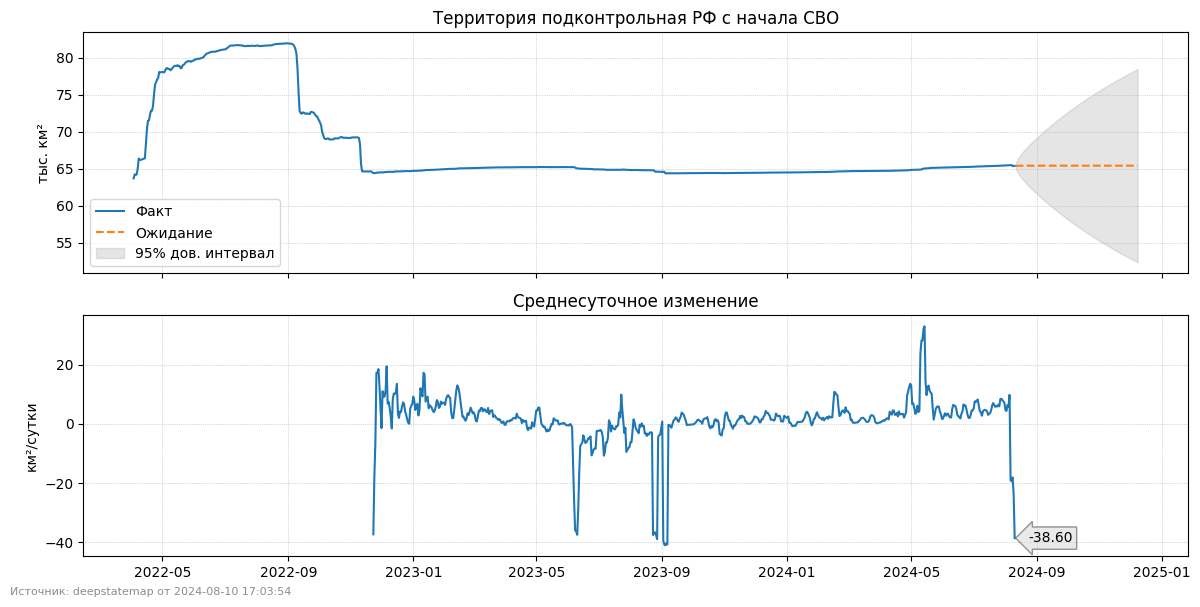

In [31]:
# sns.set_style("whitegrid")
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
ax = axs[0]
sns.lineplot(aa["area"] / 1000, ax=ax, label="Факт")
sns.lineplot(fcst["mean"] / 1000, ls="--", ax=ax, label="Ожидание")
fill_95p = ax.fill_between(
    fcst.index,
    fcst["mean_ci_lower"] / 1000,
    fcst["mean_ci_upper"] / 1000,
    alpha=0.2,
    color="grey",
)
fill_95p.set_label("95% дов. интервал")
ax.legend()
ax.set(
    xlabel=None,
    ylabel="тыс. км\u00b2",
    title="Территория подконтрольная РФ с начала СВО",
)
ax = axs[1]
ax.set(
    xlabel=None,
    ylabel="км\u00b2/сутки",
    title="Среднесуточное изменение",
)
day_din_area = (
    aa.diff()["2022-11-23":].rolling(5, center=True,
                                     min_periods=int(5 / 2)).mean()
)
sns.lineplot(
    day_din_area["area"],
    ax=ax,
    legend=None,
)
bbox = dict(boxstyle="larrow", fc="0.8", alpha=0.4)
dy = day_din_area.iloc[-1].values[0]
dx = day_din_area.index.max()
ax.annotate(
    f"{dy:.2f}",
    (dx + datetime.timedelta(days=12 + int(fh / 60)), dy),
    # xytext=(-2, 1),
    bbox=bbox,
    va="center",
    ha="left",
)
for ax in axs:
    ax.grid(ls=":", lw=0.5)
fig.tight_layout()
fig.text(
    0,
    0,
    f"Источник: deepstatemap от {last_date}",
    fontdict={"size": 8},
    alpha=0.45,
)
Path("img/").mkdir(exist_ok=True)
fig.savefig(Path("img/area.png"), format="png", dpi=300)